In [17]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [18]:
combined_file = '/projects/cc/se_users/carlsson_ksmq649/MasterThesis/dataset/curated_data/combined_smiles_raw.csv'

In [19]:
def get_parent_fingerprints(csv): # Input csv requires the column parent_smiles
    dataset = pd.read_csv(csv)

    parent_smiles = np.array(dataset['parent_smiles'].tolist())
    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]

    # Convert ExplicitBitVect to numpy arrays
    parent_fps_array = [np.array(fp) for fp in parent_fps]

    dataset['fps'] = parent_fps_array

    return dataset

def get_child_fingerprints(csv): # Input csv requires the column child_smiles
    dataset = pd.read_csv(csv)

    child_smiles = np.array(dataset['child_smiles'].tolist())
    child_mol = [Chem.MolFromSmiles(x) for x in child_smiles]
    child_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in child_mol]

    # Convert ExplicitBitVect to numpy arrays
    child_fps_array = [np.array(fp) for fp in child_fps]

    dataset['fps'] = child_fps_array

    return dataset

def do_PCA(dataset, n_pca_components=1024):
    fp_list = np.array(dataset['fps'].tolist())

    # Perform PCA
    pca = PCA(n_components=n_pca_components)
    crds = pca.fit_transform(fp_list)

    #Calculate explained variance
    explained_variance = pca.explained_variance_ratio_

    # Get principal component vectors 
    principal_components = pca.components_

    return crds, explained_variance, principal_components

def PC1_files(dataset, crds):
    
    PC1 = crds[:,0]

    df_pc1low = dataset[PC1 < 0]
    df_pc1high = dataset[PC1 > 2]

    df_pc1low.to_csv('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/data_analysis/pc1_less_than_0.csv', index=False)
    df_pc1high.to_csv('/projects/cc/se_users/carlsson_ksmq649/MasterThesis/data_analysis/pc1_greater_than_2.csv', index=False)

def get_fingerprint_comparison(csv):
    dataset = pd.read_csv(csv)

    parent_smiles = np.array(dataset['parent_smiles'].tolist())
    parent_mol = [Chem.MolFromSmiles(x) for x in parent_smiles]
    parent_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in parent_mol]
    parent_fps_array = np.array([np.array(fp) for fp in parent_fps])

    child_smiles = np.array(dataset['child_smiles'].tolist())
    child_mol = [Chem.MolFromSmiles(x) for x in child_smiles]
    child_fps = [AllChem.GetMorganFingerprintAsBitVect(x, radius=2, nBits=1024) for x in child_mol]
    child_fps_array = np.array([np.array(fp) for fp in child_fps])

    comparison_fps_array = parent_fps_array - child_fps_array

    dataset['fps'] = comparison_fps_array.tolist()

    return dataset



In [20]:
def plot_pca(crds, explained_variance, dataset):
    source_column = np.array(dataset['source'].tolist())
    crds_array = np.array(crds)

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot DrugBank data
    drugbank_mask = source_column == 'DrugBank'
    plt.scatter(crds_array[drugbank_mask, 0], crds_array[drugbank_mask, 1],  
                color='orange', marker='^', label='DrugBank')

    # Plot MetXBio data
    metxbio_mask = source_column == 'MetXBioDB'
    plt.scatter(crds_array[metxbio_mask, 0], crds_array[metxbio_mask, 1],  
                color='purple', marker='o', label='MetXBioDB')

    plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% variance)')
    plt.title('PCA of DrugBank and MetXBio Molecules - Morgan Fingerprints')
    plt.legend()
    plt.grid(True)
    plt.show()

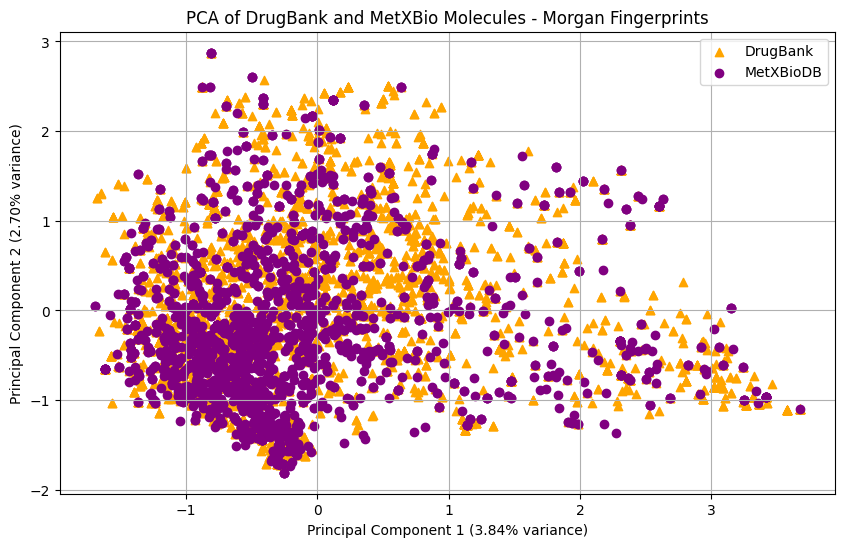

In [21]:
dataset = get_parent_fingerprints(combined_file)
crds, explained_variance, principal_components = do_PCA(dataset, 1024)
plot_pca(crds, explained_variance, dataset)


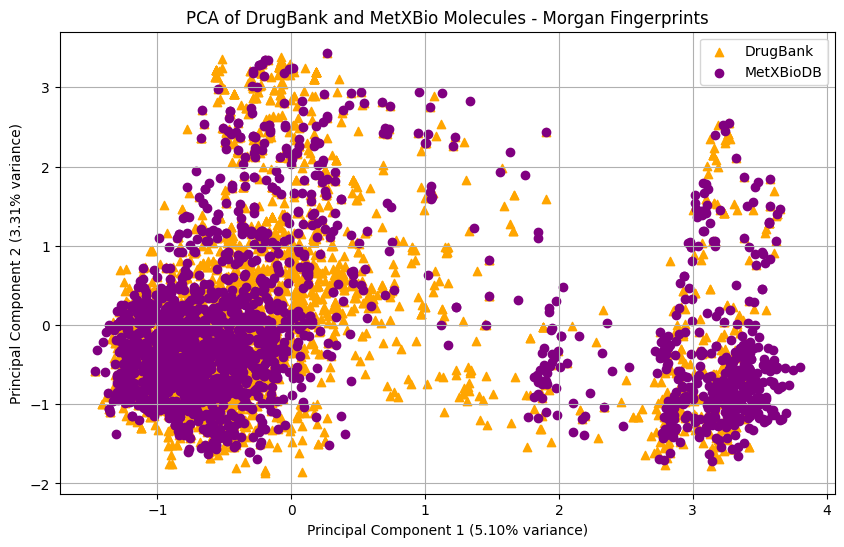

In [22]:
dataset = get_child_fingerprints(combined_file)
crds, explained_variance, principal_components = do_PCA(dataset, 1024)
plot_pca(crds, explained_variance, dataset)

PC1_files(dataset, crds)

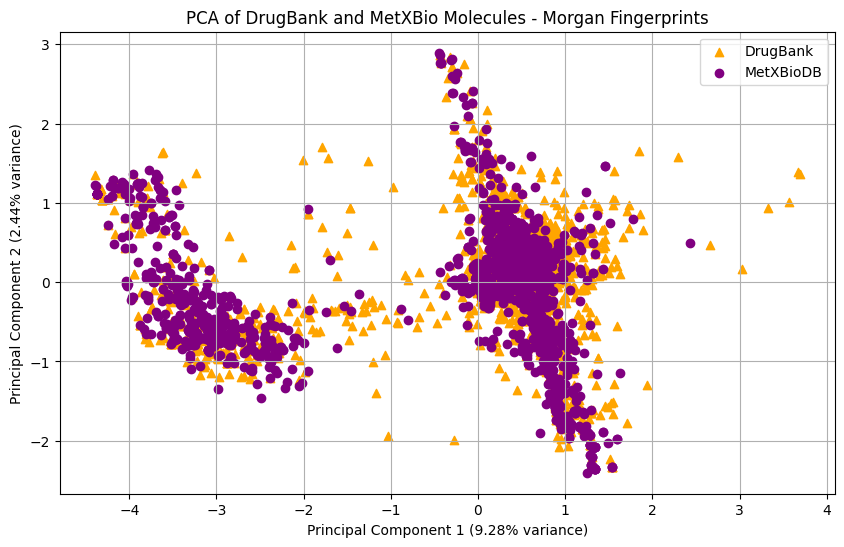

In [23]:
dataset = get_fingerprint_comparison(combined_file)
crds, explained_variance, principal_components = do_PCA(dataset)
plot_pca(crds, explained_variance, dataset)

In [24]:
def molecular_weight_analysis(dataset): # input dataset needs columns 'parent_smiles' and 'child_smiles'

    metabolite_weights, parent_weights, weight_diff_list = [], [], []

    parents = dataset["parent_smiles"]
    metabolites = dataset["child_smiles"]

    for parent, metabolite in zip(parents, metabolites):

        metabolite_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(metabolite))
        metabolite_weights.append(metabolite_weight)

        parent_weight = Descriptors.ExactMolWt(Chem.MolFromSmiles(parent))
        parent_weights.append(parent_weight)

        weight_diff = (parent_weight-metabolite_weight)
        weight_diff_list.append (weight_diff)

    dataset["weight_diff"] = weight_diff_list
    return dataset


def plot_pca_weight(crds, explained_variance, dataset):  
    source_column = np.array(dataset['source'].tolist())
    weight_diff = np.array(dataset['weight_diff'].tolist())
    crds_array = np.array(crds)

    # Plot
    plt.figure(figsize=(10, 6))

    drugbank_mask = source_column == 'DrugBank'
    positive_mask = weight_diff > 0
    negative_mask = weight_diff < 0

    heavy_parent = '#481567FF'
    light_parent = '#1F968BFF'

    # Positive weight_diff for DrugBank
    plt.scatter(crds_array[drugbank_mask & positive_mask, 0], crds_array[drugbank_mask & positive_mask, 1],  
                color=heavy_parent, marker='x', label='DrugBank (weight_diff > 0)', alpha=0.8)

    # Negative weight_diff for DrugBank
    plt.scatter(crds_array[drugbank_mask & negative_mask, 0], crds_array[drugbank_mask & negative_mask, 1],  
                color=light_parent, marker='x', label='DrugBank (weight_diff < 0)' ,alpha=0.8)

    # Plot MetXBioDB data
    metxbio_mask = source_column == 'MetXBioDB'

    # Positive weight_diff for MetXBioDB
    plt.scatter(crds_array[metxbio_mask & positive_mask, 0], crds_array[metxbio_mask & positive_mask, 1],  
                color=heavy_parent, marker='o', label='MetXBioDB (weight_diff > 0)', alpha=0.5)

    # Negative weight_diff for MetXBioDB
    plt.scatter(crds_array[metxbio_mask & negative_mask, 0], crds_array[metxbio_mask & negative_mask, 1],  
                color=light_parent, marker='o', label='MetXBioDB (weight_diff < 0)', alpha=0.5)

    plt.xlabel(f'Principal Component 1 ({explained_variance[0]*100:.2f}% variance)')
    plt.ylabel(f'Principal Component 2 ({explained_variance[1]*100:.2f}% variance)')
    plt.title('PCA of DrugBank and MetXBio Molecules - Morgan Fingerprints')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
dataset = get_fingerprint_comparison(combined_file) #returns a dataset with fingerprint comparison
dataset = molecular_weight_analysis(dataset) # adds column with weight differences
crds, explained_variance, principal_components = do_PCA(dataset)

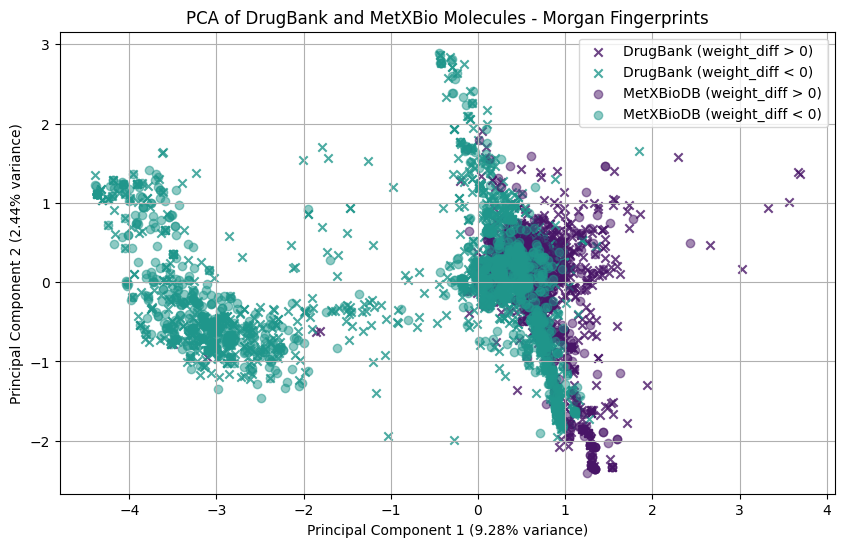

In [26]:
plot_pca_weight(crds, explained_variance, dataset)